# Описание проекта

## Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Критерии оценки проекта «Телеком»

- Целевой признак: столбец `'EndDate'` равен `'No'`.

- Основная метрика: AUC-ROC ≥ 0.88

- Дополнительная метрика: Accuracy.

### Описание услуг

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*)

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':14})

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

Загружаем датасеты и смотрим на данные

In [3]:
for df in (df_contract, df_personal, df_internet, df_phone):
    display(df.head())
    print(df.info())    

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


Имеем 7043 клиента, из которых только 5517 подключили услуги интернета без услуг стационарного телефона, и 6361 клиента, кто подключил услуги стационарного телефона.

## Предобработка данных

In [4]:
# Соберем все данные в одну таблицу
df = (df_contract.
      join(df_personal).
      join(df_internet).
      join(df_phone))
df.head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Имеем неверный формат дат, а также неверный формат колонки TotalCharges - проверим, почему так.

In [6]:
df[df['TotalCharges']==' ']

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Имеем 11 клиентов, кто оформил подписку 1 февраля 2020 года, этих клиентов мы уберем из данных, тк на них нет статистики еще.

In [7]:
df = df.drop(index = df[df['TotalCharges']==' '].index)

In [8]:
df['TotalCharges'] = df['TotalCharges'].astype('float')
df.BeginDate = pd.to_datetime(df.BeginDate, format = '%Y-%m-%d', errors = 'coerce')

In [9]:
# Используем функцию для расчета кол-ва дней подключения
def days_count(row):
    if row['EndDate']=='No':
        row['Days_count'] = (pd.to_datetime('2020-02-01') - row['BeginDate']).days
        row['EndDate'] = 0
    else:
        row['Days_count'] = (pd.to_datetime(row['EndDate'], format='%Y-%m-%d', errors='coerce') - row['BeginDate']).days
        row['EndDate'] = 1
    return row

In [10]:
df = df.apply(days_count, axis = 1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7032 non-null   datetime64[ns]
 1   EndDate           7032 non-null   int64         
 2   Type              7032 non-null   object        
 3   PaperlessBilling  7032 non-null   object        
 4   PaymentMethod     7032 non-null   object        
 5   MonthlyCharges    7032 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7032 non-null   object        
 8   SeniorCitizen     7032 non-null   int64         
 9   Partner           7032 non-null   object        
 10  Dependents        7032 non-null   object        
 11  InternetService   5512 non-null   object        
 12  OnlineSecurity    5512 non-null   object        
 13  OnlineBackup      5512 non-null   object        
 14  DeviceProtecti

Видим, что есть порядка 1500 пропусков в данных по услугам, это связано с тем, что данные в таблицах были разными и при склейке таблиц образовались пропуски в строках, а это означает, что клиенты данные услуги оператора не подключали и ими не пользуются, поэтому можно заменить все пропуски на "No - не пользуется"

In [12]:
df.replace(np.nan, 'No', inplace=True)
df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
Days_count          0
dtype: int64

In [13]:
df.drop('BeginDate', axis=1, inplace=True)
df.head()

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days_count
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31
5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036
3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61
7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61


## Исследование данных

Построим корреляционную термограмму для определения влияния признаков друг на друга, в случае, если влияние будет больше 80% - будем считать этот признак дублирующим, наличие которого необязательно для вычислений

<AxesSubplot:>

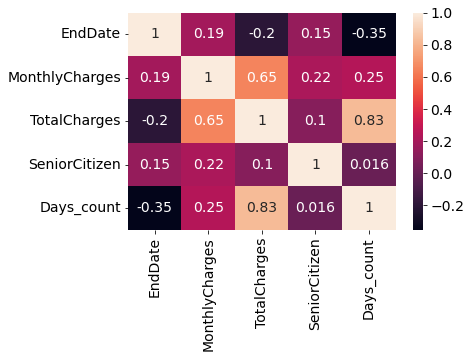

In [14]:
sns.heatmap(df.corr(), annot=True)

Видим, что TotalChanges имеет корреляцию с кол-вом дней подписки, поэтому этот признак можно удалить

In [15]:
df.drop('TotalCharges', inplace=True, axis=1)

Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл. Для каждой группы посчитаем статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Построим гистограммы распределения.

Сравним поведение клиентов этих двух групп. Для каждой группы построим графики, изображающие:

долю пользователей телефонной связи;
долю интернет-пользователей.

In [16]:
# Группа оставшихся в компании клиентов
df[df.EndDate==0].MonthlyCharges.describe()

count    5163.000000
mean       61.307408
std        31.094557
min        18.250000
25%        25.100000
50%        64.450000
75%        88.475000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [17]:
# Группа ушедших из компании клиентов
df[df.EndDate==1].MonthlyCharges.describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [18]:
# !pip install --upgrade seaborn

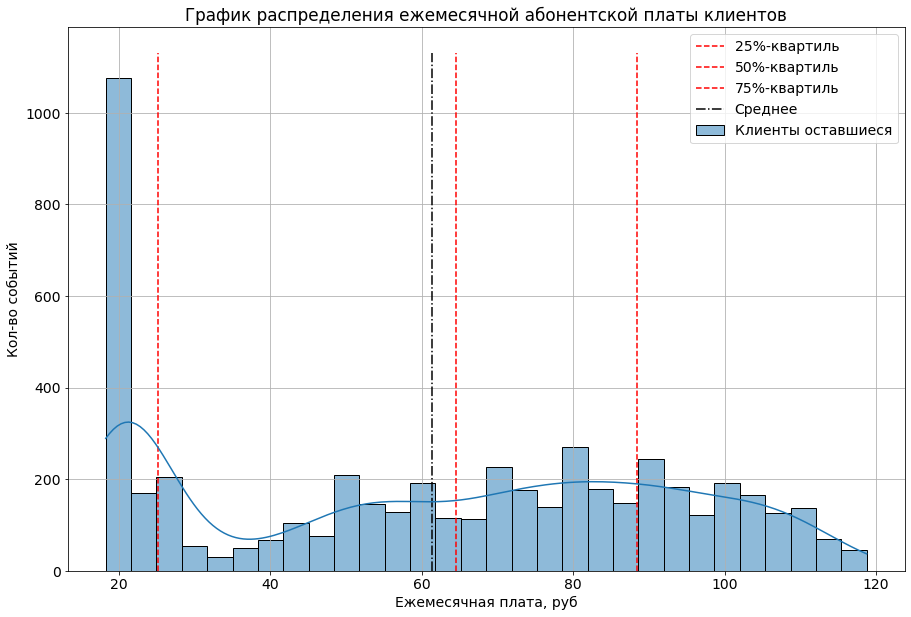

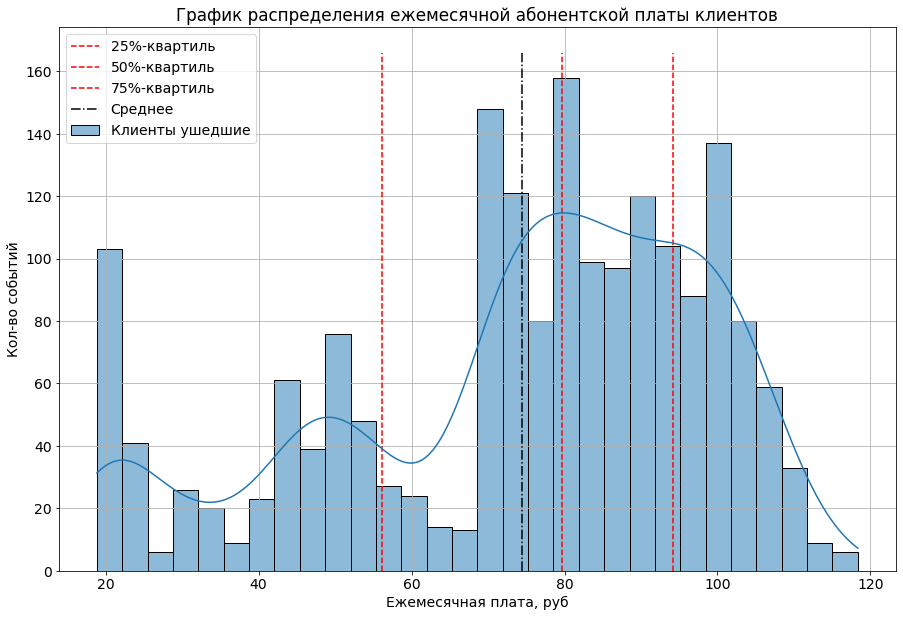

In [19]:
for i in range(len(df.EndDate.unique())):
    if i == 0:
        lbl = 'Клиенты оставшиеся'
    else:
        lbl = 'Клиенты ушедшие'
        
    plt.figure(figsize=(15,10))
    
    sns.histplot(df[df.EndDate==i].MonthlyCharges, 
                 bins = 30, 
                 kde=True, 
                 label = lbl)
    
    ymax = plt.axis()[3]
    plt.vlines(df[df.EndDate==i].MonthlyCharges.describe()['25%'],
               ymin=0,
               ymax=ymax, 
               label ='25%-квартиль', 
               linestyles='dashed', 
               colors = 'red')
    
    plt.vlines(df[df.EndDate==i].MonthlyCharges.describe()['50%'],
               ymin=0, 
               ymax=ymax, 
               label ='50%-квартиль', 
               linestyles='dashed',
               colors = 'red')
    
    plt.vlines(df[df.EndDate==i].MonthlyCharges.describe()['75%'],
               ymin=0, 
               ymax=ymax, 
               label ='75%-квартиль', 
               linestyles='dashed',
               colors = 'red')
    
    plt.vlines(df[df.EndDate==i].MonthlyCharges.describe()['mean'],
               ymin=0, 
               ymax=ymax, 
               label ='Среднее', 
               linestyles='dashdot',
               colors = 'black')
    
    plt.title('График распределения ежемесячной абонентской платы клиентов')
    plt.xlabel('Ежемесячная плата, руб')
    plt.ylabel('Кол-во событий')
    plt.grid(True)
    plt.legend()
    plt.show()

Из гистограмм видно, что возможной причиной ухода стала высокая ежемесячная плата за услуги: от 70 до 100р

Определим уникальных клиентов, кто пользуется моноуслугами интернета и телефона и найдем их долю, относительно оставшихся в компании клиентов и ушедших из нее

In [20]:
df_uniq_inet = set(df_internet.index)-set(df_phone.index)
len(df_uniq_inet)

682

In [21]:
df_uniq_phone = set(df_phone.index)-set(df_internet.index)
len(df_uniq_phone)

1526

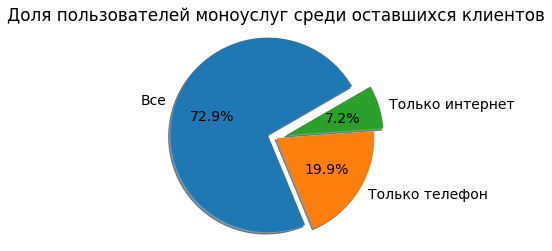

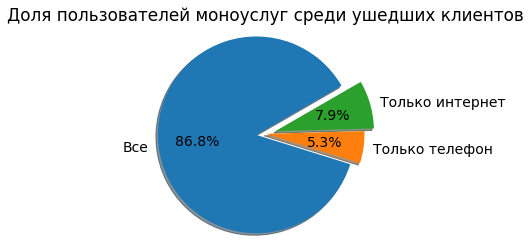

In [22]:
for i in range(len(df.EndDate.unique())):
    if i == 0:
        lbl = 'оставшихся клиентов'
    else:
        lbl = 'ушедших клиентов'
    labels = ['Все', 'Только телефон', 'Только интернет']
    data = [df[df.EndDate==i].shape[0], df[df.index.isin(df_uniq_phone)].loc[df.EndDate==i].shape[0], df[df.index.isin(df_uniq_inet)].loc[df.EndDate==i].shape[0]]
    explode = (0.1, 0, 0.1)
    plt.pie(data, explode=explode, labels = labels, autopct='%.1f%%', shadow=True, startangle=30)
    plt.title(f'Доля пользователей моноуслуг среди {lbl}')
    plt.axis('equal')
    plt.show()

Видим, что процент пользователей только интернетом среди ушедших клиентов и оставшихся примерно одинаков 7,2% - 7,9%, а вот процент пользователей только телефоном заметно выше у оставшихся в компании пользователей (почт 20% против 5,3%), что, вероятно, говорит о более выгодных тарифах/условиях для пользователей интернет+телефония у конкурентов, стоит присмотреться к этому вопросу

Построим столбчатые диаграммы типа подключения интернета и типа абонентской подписки

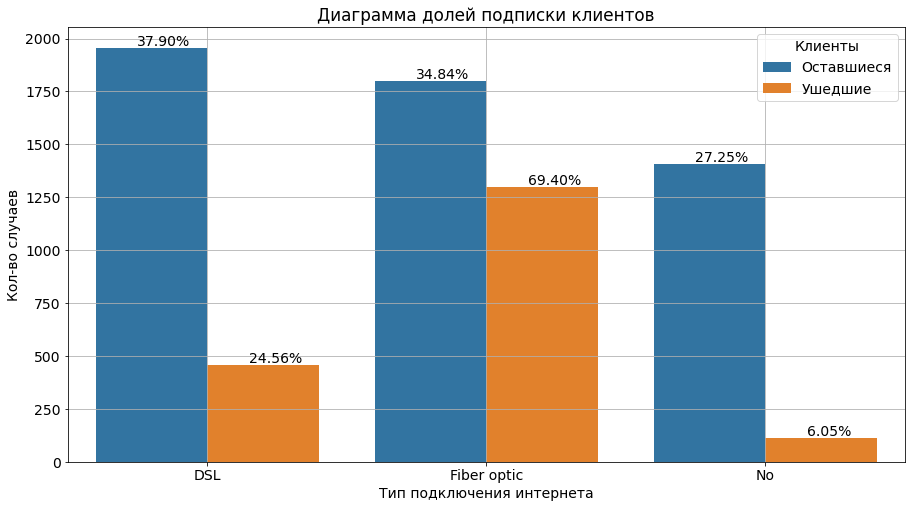

In [23]:
perc_list = []
for i in df.EndDate.unique():
    for n in list((df.groupby(by=['EndDate', 'InternetService'])['InternetService'].count()[i]/df.EndDate.value_counts()[i]).values*100):
        perc_list.append(n)

fig, ax = plt.subplots(figsize = (15, 8))
ax = sns.countplot(data=df, x='InternetService', hue='EndDate')
for i in range(len(ax.patches)):
    ax.annotate('{:.2f}%'.format(perc_list[i]),
                (ax.patches[i].get_x()+0.15, ax.patches[i].get_height()+10))
plt.legend(labels=['Оставшиеся', 'Ушедшие'], title='Клиенты')
plt.title('Диаграмма долей подписки клиентов')
plt.grid(True)
plt.xlabel('Тип подключения интернета')
plt.ylabel('Кол-во случаев')
plt.show()

Видим, что почти 70% ушедших клиентов были подключены через опто-волоконную линию - видимо, цена за подключение у конкуретна оказалась привлекательнее, доли оставшихся клиентов в компании на DSL и ОВЛ подключении практически одинаковые: 38% и 35%

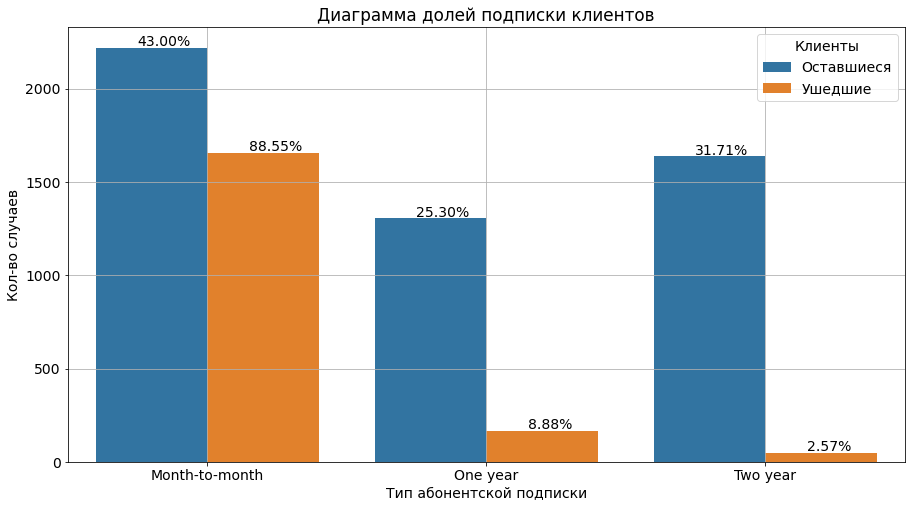

In [24]:
perc_list = []
for i in df.EndDate.unique():
    for n in list((df.groupby(by=['EndDate', 'Type'])['Type'].count()[i]/df.EndDate.value_counts()[i]).values*100):
        perc_list.append(n)
        
fig, ax = plt.subplots(figsize = (15, 8))
ax = sns.countplot(data=df, x='Type', hue='EndDate')
for i in range(len(ax.patches)):
    ax.annotate('{:.2f}%'.format(perc_list[i]),
                (ax.patches[i].get_x()+0.15, ax.patches[i].get_height()+10))
plt.legend(labels=['Оставшиеся', 'Ушедшие'], title='Клиенты')
plt.title('Диаграмма долей подписки клиентов')
plt.grid(True)
plt.xlabel('Тип абонентской подписки')
plt.ylabel('Кол-во случаев')
plt.show()

Из графика видим, что основная масса клиентов как оставшихся (43%), так и ушедших (88,5%) предпочитают помесячную оплату услуг. Однако, 88,5% это очень большая цифры, следует более внимателньо изучить этих клиентов, чтобы понять причину ухода из компании

## Машинное обучение

### Загрузка библиотек

Отделим целевой признак от массива данных и разделим на обучающую и тестовую выборки

In [27]:
X = df.drop('EndDate', axis =1)
y = df.EndDate

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

In [29]:
print(X_train.shape, X_test.shape)

(5625, 17) (1407, 17)


Создадим функцию обученя моделей, сгруппируем столбцы по категориям для дальнейшего масштабирования

In [30]:
numeric_features = ['MonthlyCharges', 'Days_count']
categoric_features = list(set(X)-set(numeric_features)-set(['SeniorCitizen']))

### Обучение модели

In [31]:
def model_train(classifier, param_grid, top10=X_train.columns, num_features=numeric_features, cat_features=categoric_features):
    if len(top10) == 10:
        num_features = list(set(num_features).intersection(set(top10)))
        cat_features = list(set(cat_features).intersection(set(top10)-set(num_features)))
    else:
        num_features = numeric_features
        cat_features = categoric_features
        
    preprocessor = ColumnTransformer(
        transformers = [
                        ('num', StandardScaler(), num_features),
                        ('cat', OneHotEncoder(drop='first'), cat_features)
                        ],
                        remainder = 'passthrough'
                        )
    clf = Pipeline(steps = [('preprocessor', preprocessor),
                            ('classifier', classifier)])
    grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, scoring = 'roc_auc', verbose = 4).fit(X_train[top10],y_train)
    # print(grid.best_params_)
    return grid.best_estimator_, grid.best_score_

In [32]:
def feat_importance(model):
    results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    return pd.Series(results.importances_mean, index=feature_name)

Для ускорения процесса все гиперпараметры будут уже заранее подобраны

In [33]:
names = [
        # 'DecisionTreeClassifier',
        'RandomForestClassifier',
        'LogisticRegression',
        # 'KNeighborsClassifier',
        'LGBMClassifier',
        'CatBoostClassifier'
        ]
classifiers = [
            #    DecisionTreeClassifier(),
               RandomForestClassifier(),
               LogisticRegression(),
            #    KNeighborsClassifier(),
               LGBMClassifier(),
               CatBoostClassifier()
]
parameters = [
            #   {'classifier__criterion':['gini'],
            #    'classifier__max_depth':[5],
            #    'classifier__class_weight':['balanced'],
            #    'classifier__random_state':[42]
            #    },
              {'classifier__n_estimators':[100],
               'classifier__criterion':['entropy'],
               'classifier__max_depth':[9],
               'classifier__class_weight':['balanced'],
               'classifier__random_state':[42]
               },
              {'classifier__penalty':['l2'],
               'classifier__C':[1],
               'classifier__solver':['sag'],
               'classifier__class_weight':['balanced'],
               'classifier__random_state':[42]
               },
            #   {'classifier__n_neighbors':[7],
            #    'classifier__weights':['uniform'],
            #    'classifier__algorithm':['kd_tree']
            #    },
              {'classifier__num_leaves':[16],
               'classifier__max_depth':[9],
               'classifier__n_estimators':[241],
               'classifier__learning_rate':[0.1],
               'classifier__class_weight':['balanced'],
               'classifier__random_state':[42]
               },
              {
               'classifier__iterations':[1000],
               'classifier__loss_function':['Logloss'],
               'classifier__learning_rate':[0.1],
               'classifier__depth':[4],
               'classifier__logging_level':['Silent'],
               'classifier__random_state':[42]   
              }
              ]

Создадим таблицу результатов обучения

In [34]:
column = ['ROC AUC на тесте', 'ROC AUC на валидации', 'Accuracy', 'Recall', 'Precision', 'Время обучения, сек', 'Название модели', 'Модель', 'Predict_proba']
results = pd.DataFrame(columns = column)

In [35]:
for name, classifier, param_grid in zip(names, classifiers, parameters):
    start_time = time.time()
    model, score = model_train(classifier, param_grid)
    train_time = round(time.time()-start_time, 2)
    y_pred = model.predict(X_test)
    results = pd.concat(
        [results, pd.DataFrame(
            [[round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3),
              round(score,3),
              round(accuracy_score(y_test, y_pred),3),
              round(recall_score(y_test, y_pred, average='binary'),3),
              round(precision_score(y_test, y_pred, average='binary'),3),
              train_time,
              name,
              model,
              model.predict_proba(X_test)[:,1]
             ]],
            columns = column,
            index = [name])])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [36]:
results.sort_values(by='ROC AUC на тесте', ascending=False)

,ROC AUC на тесте,ROC AUC на валидации,Accuracy,Recall,Precision,"Время обучения, сек",Название модели,Модель,Predict_proba
CatBoostClassifier,0.924,0.926,0.880,0.679,0.838,8.45,CatBoostClassifier,"(ColumnTransformer(remainder='passthrough',\n ...","[0.002521191939576032, 0.0869572024703457, 0.0..."
LGBMClassifier,0.917,0.903,0.841,0.789,0.670,1.05,LGBMClassifier,"(ColumnTransformer(remainder='passthrough',\n ...","[0.0012911509983059945, 0.26039760774424336, 0..."
RandomForestClassifier,0.851,0.856,0.766,0.770,0.542,3.13,RandomForestClassifier,"(ColumnTransformer(remainder='passthrough',\n ...","[0.01510325887198911, 0.7827109756154372, 0.03..."
LogisticRegression,0.833,0.844,0.729,0.783,0.493,0.30,LogisticRegression,"(ColumnTransformer(remainder='passthrough',\n ...","[0.05446199747168056, 0.7990696707790547, 0.02..."


Бустинговые модели Catboost и LightGBM показали довольно близкие метрики, серьезно обогнав классические модели, что вполне ожидаемо, однако, Catboost существенно обходит LightGBM по точностям Accuracy и Precision, но проигрывает по Полноте (Recall) метрике. 

Построим график ROC-кривой для всех обученных моделей

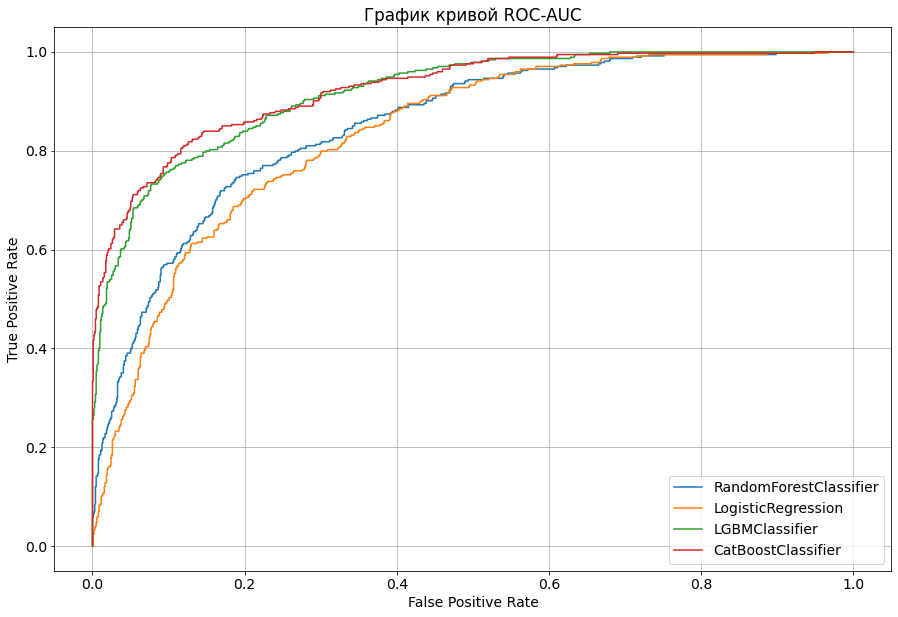

In [37]:
plt.figure(figsize=(15,10))
for i in range(results.shape[0]):
    fpr, tpr, _ = roc_curve(y_test, results['Predict_proba'][i])
    plt.plot(fpr, tpr, label = results.index[i])
    plt.title('График кривой ROC-AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend()

На графике видим, что кривые Catboost и LightGBM довольно близки между собой, что подтверждается расчетами 0.924 против 0.917. Логистическая Регрессия оказалась самой слабой моделью.

### Важность признаков

In [38]:
clf=permutation_importance(
    results.sort_values(by='ROC AUC на тесте', ascending=False)['Модель'][0],
    X_test, y_test, n_repeats=20, random_state=42)

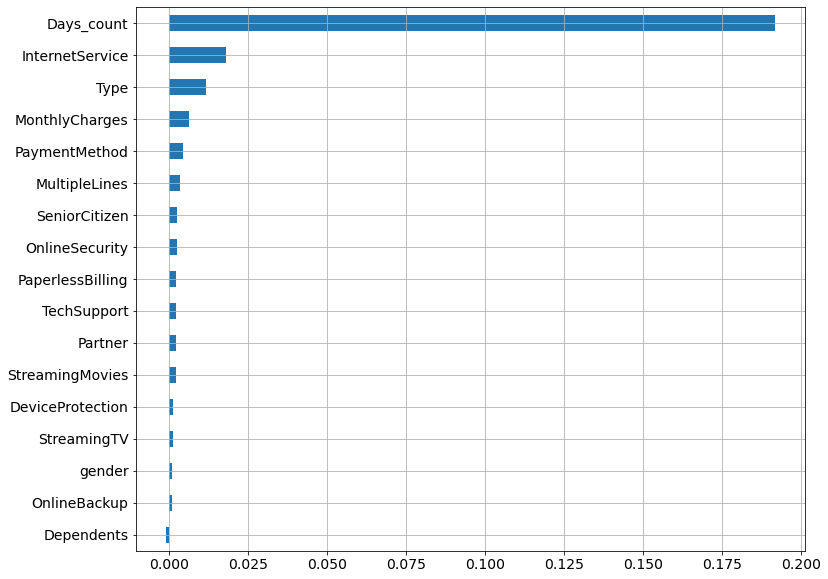

In [39]:
plt.figure(figsize=(12,10))
pd.Series(clf.importances_mean, index=X_test.columns).sort_values(ascending=True).plot.barh()
plt.grid(True)

Из диаграммы видно, что многие признаки имеют крайне малый вес, обучим лучшую модель на топ 10 признаках и сравним результаты

In [40]:
top10 = list(pd.Series(clf.importances_mean, index=X_test.columns).sort_values(ascending=False).index[:10])
model1, score1 = model_train(CatBoostClassifier(), parameters[3], top10=top10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [41]:
y_pred = model1.predict(X_test[top10])
roc_auc1 = round(roc_auc_score(y_test, model1.predict_proba(X_test[top10])[:,1]),3)
accur1 = round(accuracy_score(y_test, y_pred),3)
precision1 = round(precision_score(y_test, y_pred, average='binary'),3)
recall1 = round(recall_score(y_test, y_pred, average='binary'),3)
print(f'ROC_AUC= {roc_auc1}, Accuracy= {accur1},\nPrecision ={precision1}, Recall= {recall1}')

ROC_AUC= 0.931, Accuracy= 0.881,
Precision =0.853, Recall= 0.668


In [42]:
def draw_graphs(y_pred, y_proba, title):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(15,6)
    fig.suptitle(title, fontsize=24)
    ax[0].title.set_text('Матрица ошибок')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax[0])
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax[1].plot(fpr,tpr)
    ax[1].title.set_text("График кривой ROC-AUC")
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].grid(True)
    ax[1].text(x=0.4, y=0.4, s=f'ROC AUC={round(roc_auc_score(y_test, y_proba),3)}', fontsize=24)
    ax[1].text(x=0.4, y=0.1, s=f'Recall={round(recall_score(y_test, y_pred),3)}', fontsize=24)
    ax[1].text(x=0.4, y=0.2, s=f'Precision={round(precision_score(y_test, y_pred),3)}', fontsize=24)
    ax[1].text(x=0.4, y=0.3, s=f'Accuracy={round(accuracy_score(y_test, y_pred),3)}', fontsize=24)
    plt.show()

### Сравнение моделей на разном кол-ве признаков

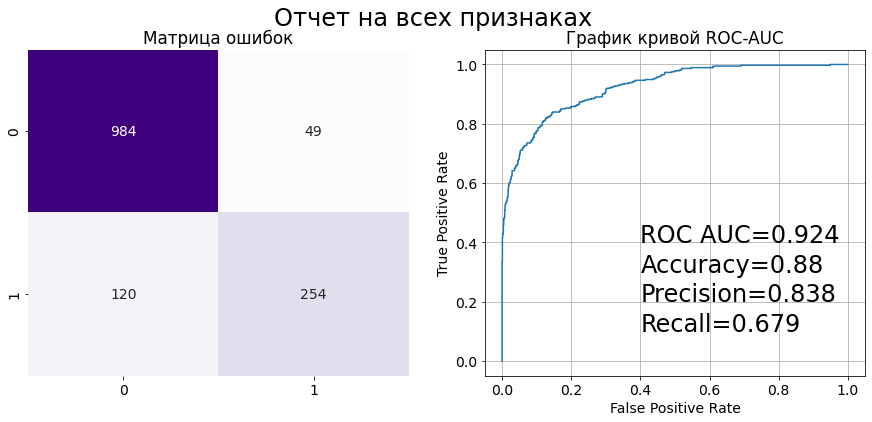

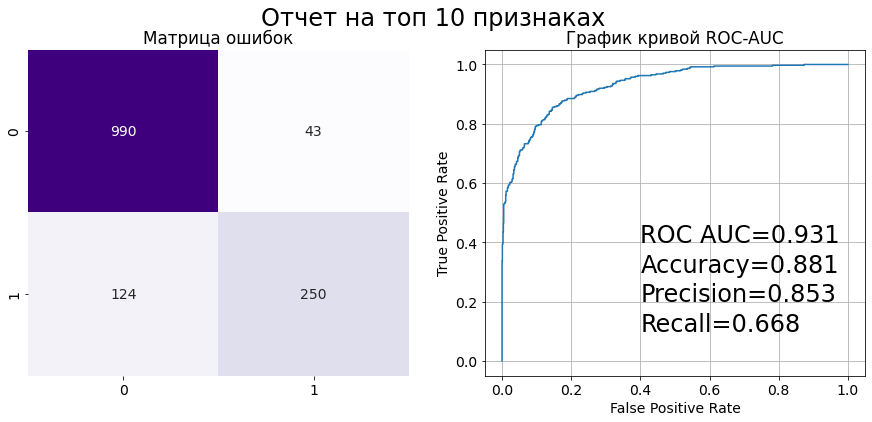

In [43]:
y_proba = results.sort_values(by='ROC AUC на тесте', ascending=False)['Модель'][0].predict_proba(X_test)[:,1]
y_pred = results.sort_values(by='ROC AUC на тесте', ascending=False)['Модель'][0].predict(X_test)
draw_graphs(y_pred, y_proba, 'Отчет на всех признаках')
y_proba = model1.predict_proba(X_test[top10])[:,1]
y_pred = model1.predict(X_test[top10])
draw_graphs(y_pred, y_proba, 'Отчет на топ 10 признаках')

## Вывод

В данной работе мы провели исследование поведения клиентов, которые покинули компанию: 73% клиентов, кто пользуется услугами интернета и телефонии, остались в компании против 87% клиентов среди ушедших - стоит задуматься маркетингу, почему так происходит. Большинство, кто ушел, платил высокую абонентскую плату от 70 до 100р в месяц, в то время как оставшиеся клиенты платят 20р в месяц.

Также мы обучили несколько моделей для получения наилучшей метрики кривой ROC AUC, лучший показатель в 0,926 показала модель Catboost с точностью Accuracy = 0,875. Мы посмотрели важность признаков: самый значимый вес имеет признак кол-ва дней подписки клиента, затем тип интернет-подключения и тип подписки. 

Для эксперимента лучшая модель была заново обучена на топ10 признаках, значимость которых оказывает влияние на целевую функцию, построены матрицы ошибок, кривые ROC AUC, посчитаны Accuracy, Recall, Precision - в целом, существенной разницы мы не наблюдаем, метрики практически идентичны, матрицы ошибок чуть лучше при использовании всех признаков: на 5 человек больше определяем кол-во ушедших клиентов.

# Отчет о работе

В ходе работы были выполнили все запланированные шаги: 
- Предобработку данных: загрузили таблицы и соединили в одну большую, заполнили пропуски, возникшие при соединении таблиц, посчитали кол-во дней подключения клиентов, удалили строки с новыми клиентами, по которым статистика отсутствовала, удалили столбец с суммарной выручкой, тк она коррелировала с кол-вом дней подключения, соответственно, не вносила значимых изменений для модели;
- Исследование данных: рассмотрели возможные причины ухода клиентов - высокая ежемесячная абонентская плата как одна из них, проанализировали долю клиентов, кто пользовался моноуслугами в каждой из групп, а также рассмотрели доли ушедших/оставшихся клиентов по типу подключения  по типу абонентской подписки, построили гистограммы и столбчатые диаграммы;
- Обучение моделей: рассмотрели несколько моделей (LogReg, RandomForest, LightGBM, CatBoost) классификации, определили лучшую из них - Catboost, метрика ROC AUC составила 0.926, посмотрели на диаграмму важности признаков и , обучив модель на топ10 признаках, получили незначительный прирост в метриках

Из сложностей, с которыми пришлось столкнуться, добавление значений к столбцам столбчатых диаграмм - пришлось почитать пару сайтов для ознакомления, как это сделать

Ключевыми шагами в проекте можно выделить построение корреляционной диаграммы и важности признаков, запомню на будущее обязательно их строить/смотреть

Итоговая модель это CatBoostClassifier , метрики представлены на рисунках ниже

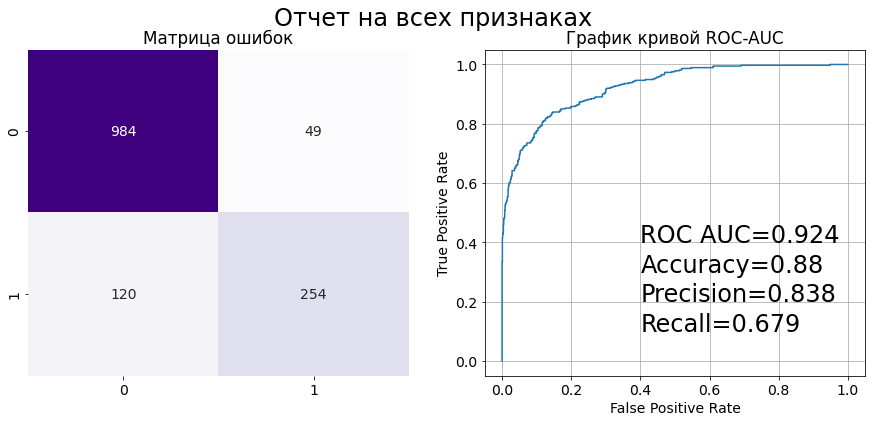
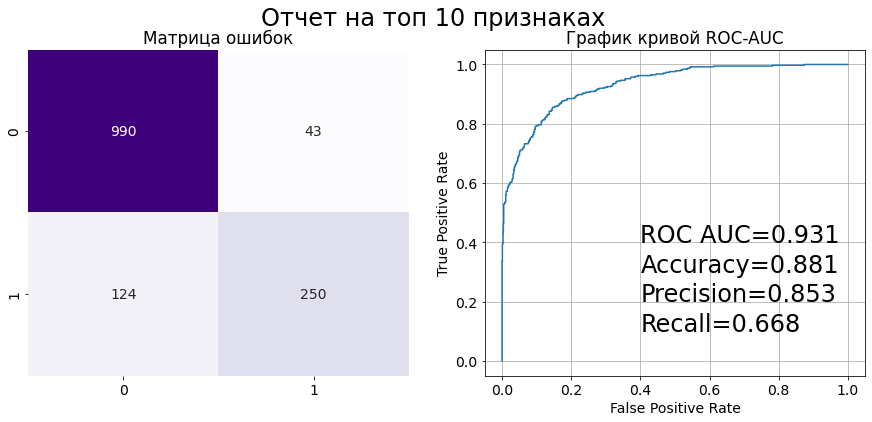